In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"taruneapen","key":"4cec1efbfec7529a9c9be86a4f255118"}'}

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [14]:
! kaggle competitions download -c new-york-city-taxi-fare-prediction

100% 1.56G/1.56G [00:17<00:00, 28.0MB/s]
100% 1.56G/1.56G [00:17<00:00, 93.4MB/s]


In [15]:
! unzip new-york-city-taxi-fare-prediction.zip

Archive:  new-york-city-taxi-fare-prediction.zip
  inflating: GCP-Coupons-Instructions.rtf  
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
# LOADING MODULES

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
%matplotlib inline

from pydoc import help
from scipy.stats.stats import pearsonr

from sklearn import datasets, linear_model
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

from datetime import datetime
from datetime import timedelta
import datetime as dt
import calendar

import math

<ipython-input-2-4b0f0f82b4de>:11: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [16]:
# READING TRAINING DATA

train = pd.read_csv('./train.csv', nrows = 1000000)
train.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

####DATA CLEANING

* Checking for missing values and removing the rows corresponding to them if any.
* Removing the rows that have -ve values of Fare amount as Fare cannot be -ve.
* Truncating longitude and latitude values to fit NY coordinates.

In [17]:
# CHECK FOR NULL ENTRIES
train[pd.isnull(train)].sum()

key                    0
fare_amount          0.0
pickup_datetime        0
pickup_longitude     0.0
pickup_latitude      0.0
dropoff_longitude    0.0
dropoff_latitude     0.0
passenger_count      0.0
dtype: object

In [18]:
# EXTRACT DATA FROM PICKUP_DATETIME FEATURE IN THE DATASET

train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], format = '%Y-%m-%d %H:%M:%S UTC')

train['pickup_hour']=train['pickup_datetime'].dt.hour
train['pickup_day']=train['pickup_datetime'].dt.day
train['pickup_month']=train['pickup_datetime'].dt.month
train['pickup_year']=train['pickup_datetime'].dt.year
train['pickup_day_of_week']=train['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
print (train.shape)
print (train.columns)

(1000000, 13)
Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'pickup_hour', 'pickup_day', 'pickup_month',
       'pickup_year', 'pickup_day_of_week'],
      dtype='object')


In [19]:
# REMOVING ENTRIES WITH -VE FARE AMOUNT

train=train.loc[train['fare_amount']>=0]

print (train.shape)

(999962, 13)


##### TRUNCATING THE LONGITUDE AND LATTITUDE COORDINATES BASED ON THAT OF NEW YORK

The Boundary Co-ordinates of New York:
https://www.mapdevelopers.com/geocode_bounding_box.php

The boundaries of New York are:  
North Latitude: 40.917577   
South Latitude: 40.477399   
East Longitude: -73.700272   
West Longitude: -74.259090  

Used the above to build a boundary by for the allowed Drop_off and Pick_up Longitude, Latittudes.

This method of data cleaning did not produce substantial results. On analysing the possible reasons for the bad behaviour of the model, I felt that the narrow possible values for the Longitude and Lattitude could be a reason.
To verify the same, I checked the boundaries of the Longitudes and Lattitudes on the Test Data and found that a lot of samples had coordinates outside the above used boundary.

Inorder to cater to this issue, I used the Test Data to obtain the boundaries on the Lattitude and Longitude.

Which came out to be  
North Latitude: 41.709555   
South Latitude: 40.573143   
East Longitude: -72.986532   
West Longitude: -74.263242  

Created the Boundary using the below values as Test Data contained co-ordinates a bit outside the boundaries specified by the link above.

In [20]:
#Before we  ahead and identify outlier location, let us read the test data and see what the boundaries are.
test =  pd.read_csv('./test.csv')

print("Longitude Boundary in test data")
print (min(test.pickup_longitude.min(), test.dropoff_longitude.min()),max(test.pickup_longitude.max(), test.dropoff_longitude.max()))

print("Latitude Boundary in test data")
print (min(test.pickup_latitude.min(), test.pickup_latitude.min()),max(test.pickup_latitude.max(), test.pickup_latitude.max()))


Longitude Boundary in test data
-74.263242 -72.986532
Latitude Boundary in test data
40.573143 41.709555


In [21]:
boundary={'north_lat':41.709555,
          'south_lat':40.573143,
          'east_long':-72.986532,
          'west_long':-74.263242}

train.loc[~((train.pickup_longitude >= boundary['west_long'] ) & (train.pickup_longitude <= boundary['east_long']) &
            (train.pickup_latitude >= boundary['south_lat']) & (train.pickup_latitude <= boundary['north_lat']) &
            (train.dropoff_longitude >= boundary['west_long']) & (train.dropoff_longitude <= boundary['east_long']) &
            (train.dropoff_latitude >=boundary['south_lat']) & (train.dropoff_latitude <= boundary['north_lat'])),'is_outlier_loc']=1
train.loc[((train.pickup_longitude >= boundary['west_long'] ) & (train.pickup_longitude <= boundary['east_long']) &
            (train.pickup_latitude >= boundary['south_lat']) & (train.pickup_latitude <= boundary['north_lat']) &
            (train.dropoff_longitude >= boundary['west_long']) & (train.dropoff_longitude <= boundary['east_long']) &
            (train.dropoff_latitude >=boundary['south_lat']) & (train.dropoff_latitude <= boundary['north_lat'])),'is_outlier_loc']=0

train=train.loc[train['is_outlier_loc']==0]
train.drop(['is_outlier_loc'],axis=1,inplace=True)
print (train.shape)

(978799, 13)


In [22]:
# CALCULATING HAVERSIAN DISTANCE

def haversian_distance(lat1, lat2, lon1,lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

train['hav_distance'] = train.apply(lambda row:haversian_distance(row['pickup_latitude'],row['dropoff_latitude'],row['pickup_longitude'],row['dropoff_longitude']),axis=1)

# CALCULATING EUCLEDIAN DISTANCE

train['euc_distance'] = 69 * np.sqrt((np.array(train.dropoff_longitude) - np.array(train.pickup_longitude))**2 + (np.array(train.pickup_latitude) - np.array(train.dropoff_latitude))**2)

print (train.columns)

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'pickup_hour', 'pickup_day', 'pickup_month',
       'pickup_year', 'pickup_day_of_week', 'hav_distance', 'euc_distance'],
      dtype='object')


#### WEATHER DATA


Weather Dataset: ​https://www.ncdc.noaa.gov/cdo-web/datasets

* This website contains the Daily Summaries of the Weather in required cities for the required period of time. And they have the data available from 1869-01-01 until so far.
* They provide large set of features like Snowfall, Snow Depth, Min Temperature, Max Temperature, Precipitation, Air Wind etc to name a few.
* Along with the above details regarding the weather, they provide the year/date/month on which that particular weather was observed. Hence, this can be used to merge this data with our existing data.
* Weather plays a huge role in the movement of taxis. The availability, prices, and demand everything can change based on the weather. Hence, incorporating details about the weather into our dataset would definitely boost our model.
* The dataset set used is https://raw.githubusercontent.com/sdaulton/TaxiPrediction/master/data/nyc-weather-data.csv
* This dataset covers Daily Summary of Weather of New York From Jan 1st 2009 to Nov 11th 2015.

Pre-processing steps similar to what is done above.

* In this dataset -9999 indicate missing values, hence replaced such values with 0

* Parsed the ‘Date’ feature to extract the following in order to be able to merge this data to our existing data. The fields: 'pickup_year', 'pickup_month' and 'pickup_day'.

* The provided data was initially parsed to have the above fields. Using these 3 fields, the initial data has been merged with this external Weather Data.

In [24]:
# EXTRACTING FEATURES FROM THE WEATHER DATASET

weather=pd.read_csv("./nyc-weather-data.csv")

# Replacing Values with -9999 with 0 as they indicate Missing Data
weather.loc[weather.SNWD <= -9999, 'SNWD'] = 0
weather.loc[weather.SNOW <= -9999, 'SNOW'] = 0
weather.loc[weather.AWND <= -9999, 'AWND'] = 0

#Extracting the Year, Month, Day with the same Column Name as that of the Existing Data for Merging
weather['pickup_year'] = (weather['DATE']/10000).apply(math.floor)
weather['pickup_month'] = ((weather['DATE'].mod(10000))/100).apply(math.floor)
weather['pickup_day'] = weather['DATE'].mod(100)
weather = weather[['pickup_year','pickup_month','pickup_day','PRCP','SNWD','SNOW','TMAX','TMIN','AWND']]

weather.columns = ['pickup_year','pickup_month','pickup_day','precipitation','snow_depth','snowfall','max_temp','min_temp','avg_wind']

In [25]:
# MERGING EXISTING DATA WITH WEATHER DATA TO GENERATE NEW FEATURES

train_new = pd.merge(train, weather, how='left', on=['pickup_year','pickup_month','pickup_day'])

print (train_new.columns)

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'pickup_hour', 'pickup_day', 'pickup_month',
       'pickup_year', 'pickup_day_of_week', 'hav_distance', 'euc_distance',
       'precipitation', 'snow_depth', 'snowfall', 'max_temp', 'min_temp',
       'avg_wind'],
      dtype='object')


In [26]:
# CHECKING FOR NULL VALUES

train_new[pd.isnull(train_new)].sum()
print (train_new.dtypes)

key                           object
fare_amount                  float64
pickup_datetime       datetime64[ns]
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
passenger_count                int64
pickup_hour                    int64
pickup_day                     int64
pickup_month                   int64
pickup_year                    int64
pickup_day_of_week            object
hav_distance                 float64
euc_distance                 float64
precipitation                  int64
snow_depth                     int64
snowfall                       int64
max_temp                       int64
min_temp                       int64
avg_wind                       int64
dtype: object


<ipython-input-26-fee9aa2e2e7b>:3: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_new[pd.isnull(train_new)].sum()


In [27]:
# FINAL TRAIN DATA SET THAT WILL BE USED FOR TRAINING AND VALIDATION

train = train_new
print (train.columns)
print (train.shape)
print (train.dtypes)

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'pickup_hour', 'pickup_day', 'pickup_month',
       'pickup_year', 'pickup_day_of_week', 'hav_distance', 'euc_distance',
       'precipitation', 'snow_depth', 'snowfall', 'max_temp', 'min_temp',
       'avg_wind'],
      dtype='object')
(978799, 21)
key                           object
fare_amount                  float64
pickup_datetime       datetime64[ns]
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
passenger_count                int64
pickup_hour                    int64
pickup_day                     int64
pickup_month                   int64
pickup_year                    int64
pickup_day_of_week            object
hav_distance                 float64
euc_distance                 float64
precipitation                  int

### Plotting the relationship between 'Distance of the ride' and 'Taxi Fare'

In [37]:
print ("Corr between Eucledian Distance and Fare Amount")
corr = pearsonr(train.fare_amount, train.euc_distance)
print (corr)

Corr between Eucledian Distance and Fare Amount
PearsonRResult(statistic=0.8257585563383669, pvalue=0.0)


Text(24.765625000000007, 0.5, 'Taxi Fare')

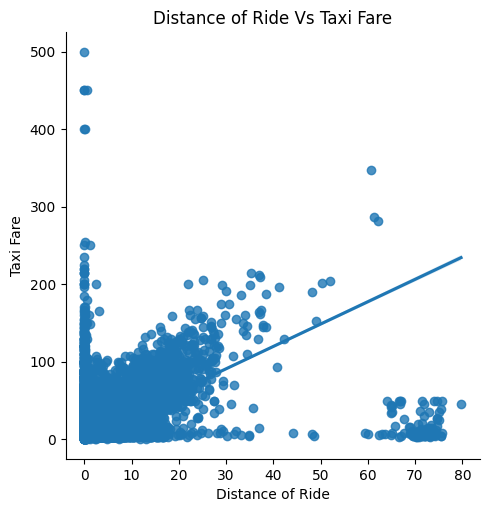

In [34]:
# Scatter Plot Between Eucledian Distance and Fare Amount

sns.lmplot(x='euc_distance', y='fare_amount', data=train)

plt.title('Distance of Ride Vs Taxi Fare')
# Set x-axis label
plt.xlabel('Distance of Ride')
# Set y-axis label
plt.ylabel('Taxi Fare')

Text(24.765625000000007, 0.5, 'Taxi Fare')

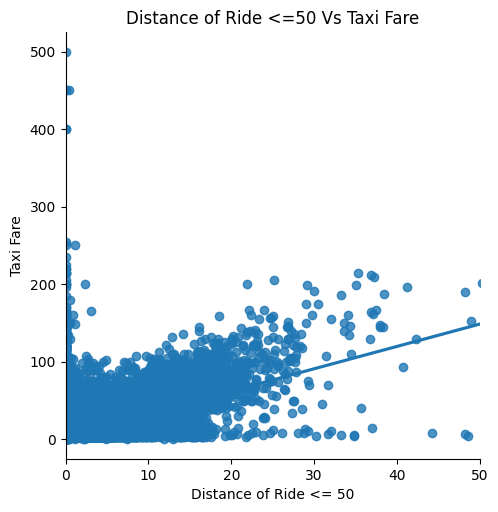

In [35]:
# Scatter Plot Between Eucledian Distance <=50 and Fare Amount

lm = sns.lmplot(x='euc_distance', y='fare_amount', data=train)

lm.set(xlim=(0, 50))
plt.title('Distance of Ride <=50 Vs Taxi Fare')
# Set x-axis label
plt.xlabel('Distance of Ride <= 50')
# Set y-axis label
plt.ylabel('Taxi Fare')

● In an ideal scenario, we can say that the Distance Travelled and Taxi Fare should be linearly related. But, it is very obvious that there are a lot of external factors that affect the relation between the two and hence we cannot say that they are completely linearly related.

● Although, as we can see in the attached plot there does exist a nearly linear relationship between the two for a lot of data samples. This is more clear in the second plot which caps the distance travelled to 50.

● One interesting aspect I think could be a depiction of the above plot is that the line describing the data is quite below the y=x line, i.e the fare for higher distances does not increase in proportion to how it does for the distances clustered around the centre.

● This is evident In the first plot where we can see a cluster of data samples at very high distances (60-80) but with quite less fare. This could be due to the Trips to the Airport which are quite long, but have fixed prices.

● Pearson Correlation depicts the strength of linearity between different parameters. A Pearson Correlation of ​0.82 does indicate quite a strong linear correlation between the Distance Travelled and Taxi Fare.


### Plotting the relationship between 'Time of day' and 'Distance Travelled'.

In [38]:
# pickup_hour is distributed from 0-23 for each hour
print ("Corr between Time of the Day and Eucledian Distance")
corr = pearsonr(train.euc_distance, train.pickup_hour)
print (corr)

Corr between Time of the Day and Eucledian Distance
PearsonRResult(statistic=-0.030505480979841088, pvalue=3.4705378017329394e-200)


Text(33.51562500000001, 0.5, 'Distance of Ride')

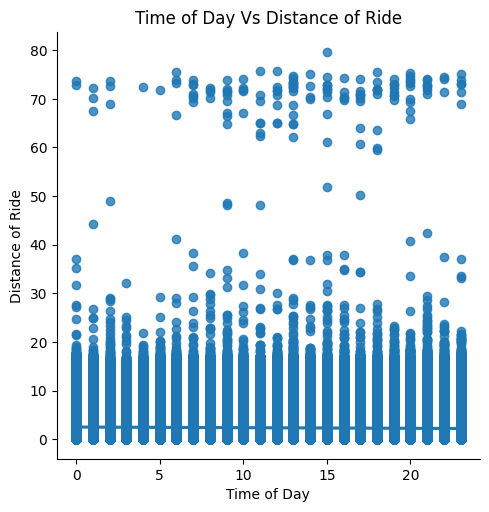

In [39]:
# Scatter Plot Between Eucledian Distance and Time of the Day

sns.lmplot(x='pickup_hour', y='euc_distance', data=train)

plt.title('Time of Day Vs Distance of Ride')
# Set x-axis label
plt.xlabel('Time of Day')
# Set y-axis label
plt.ylabel('Distance of Ride')

* Based on the plot, the Time of the Day and Distance travelled are not quite linearly related.

* The Pearson Correlation between the two is very small (​-0.031​) which means that they aren’t related much.

* Although, one interesting thing to observe is that there is a range of distances that are mostly never taken despite any part of the day, like the distances between 40-60 are very less taken. It can be assumed that the distances below that could indicate the daily commuters from home to office or vice versa, and the above half could indicate the ones who travel to the airports which tend be quite far away.

* The average distance travelled may be high at the centre (i.e. through the day than early or late night) but apart from this, there seems to be no definite linear relationship between time and the distance travelled.

### Plotting the relationship between 'Time of day' and 'Taxi Fare'.

In [40]:
print ("Corr between Time of the Day and Fare Amount")
corr = pearsonr(train.fare_amount, train.pickup_hour)
print (corr)

Corr between Time of the Day and Fare Amount
PearsonRResult(statistic=-0.019273819110088936, pvalue=4.469411431182423e-81)


Text(24.765625000000007, 0.5, 'Taxi Fare')

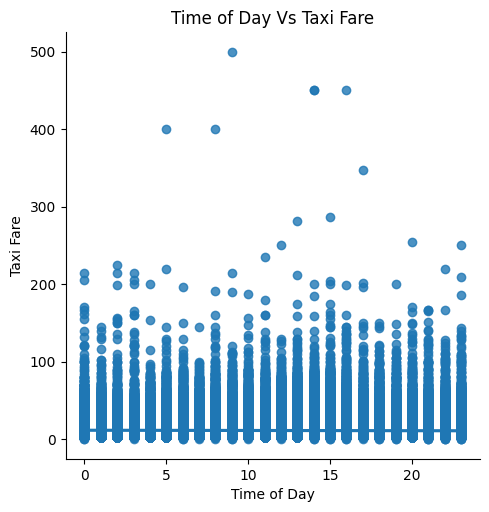

In [41]:
# Scatter Plot Between Fare Amount and Time of the Day

sns.lmplot(x='pickup_hour', y='fare_amount', data=train)

plt.title('Time of Day Vs Taxi Fare')
# Set x-axis label
plt.xlabel('Time of Day')
# Set y-axis label
plt.ylabel('Taxi Fare')

* In similar line with what was seen above, I see that there does not exist a strong linear relationship between Time of the Day and Taxi Fare either. This is indicated by very small Pearson Correlation - -.02.

* The interesting aspect about this plot are the data points that lie at high Taxi Fares in the middle of the day, and some at the end of the day. With an assumption that most travel to the airport happens either at early or late hours and with the fact that the fare for these trips is fixed, these anomalous data points would not be of the trips to the airport.

* Instead, I feel that the reason for the high fare during midday and later could be due to the increased traffic during that time that could have lead to less available cabs with surged prices, thus leading to some really high data points.

### Visualisations of the Data

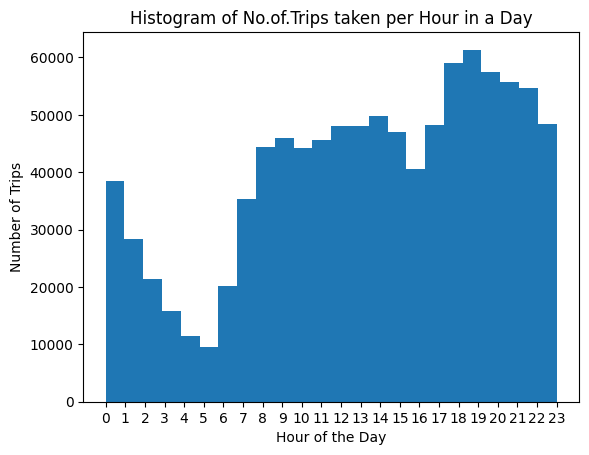

In [44]:
# Histogram of No.of.Trips taken per Hour in a Day

plt.hist(train.pickup_hour, bins=24)
plt.xticks(np.arange(0,24,step=1))
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.title('Histogram of No.of.Trips taken per Hour in a Day')
plt.show()

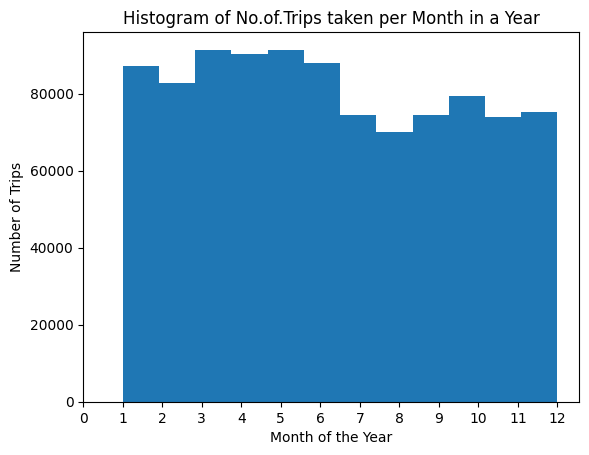

In [46]:
# Histogram of No.of.Trips taken per Month in a Year

plt.hist(train.pickup_month, bins=12)
plt.xticks(np.arange(0,13,step=1))
plt.xlabel('Month of the Year')
plt.ylabel('Number of Trips')
plt.title('Histogram of No.of.Trips taken per Month in a Year')
plt.show()

### PLOTS BETWEEN FARE AMOUNT AND WEATHER CONDITIONS

The below plots indicate the new parameters from the external New York Weather Dataset.

* The parameters are ['avg_wind', 'max_temp', 'min_temp', 'precipitation', 'snow_depth', 'snowfall'].
* These paramenters are plotted against the Fare amount to see how they were related and to check whether these features would help improve my existing model or not and I found some interesting observations.

Text(24.765625000000007, 0.5, 'Taxi Fare')

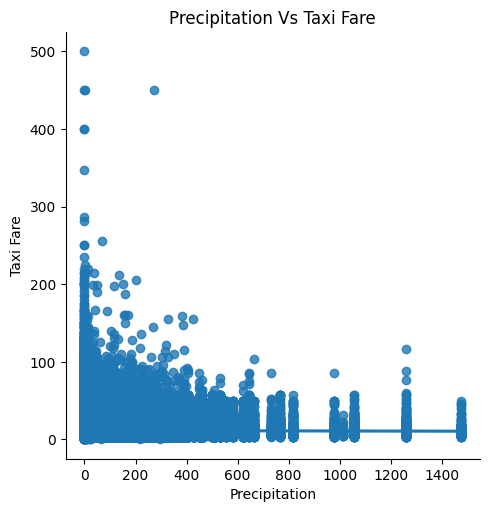

In [49]:
sns.lmplot(x='precipitation', y='fare_amount', data=train)

plt.title('Precipitation Vs Taxi Fare')
# Set x-axis label
plt.xlabel('Precipitation')
# Set y-axis label
plt.ylabel('Taxi Fare')

Text(24.765625000000007, 0.5, 'Taxi Fare')

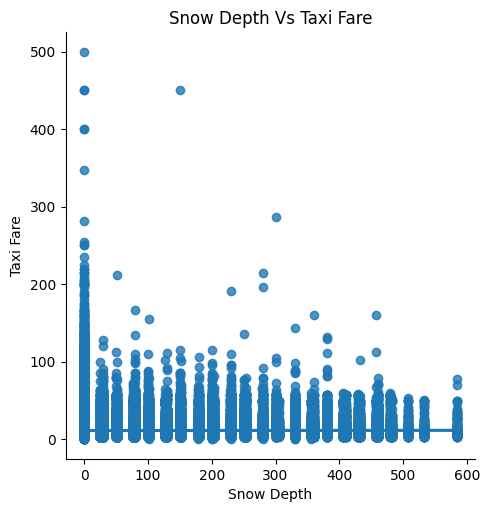

In [50]:
sns.lmplot(x='snow_depth', y='fare_amount', data=train)

plt.title('Snow Depth Vs Taxi Fare')
# Set x-axis label
plt.xlabel('Snow Depth')
# Set y-axis label
plt.ylabel('Taxi Fare')

Text(24.765625000000007, 0.5, 'Taxi Fare')

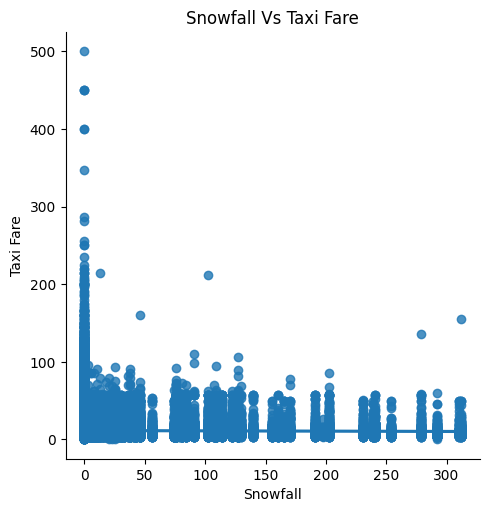

In [51]:
sns.lmplot(x='snowfall', y='fare_amount',data=train)

plt.title('Snowfall Vs Taxi Fare')
# Set x-axis label
plt.xlabel('Snowfall')
# Set y-axis label
plt.ylabel('Taxi Fare')

Text(24.765625000000007, 0.5, 'Taxi Fare')

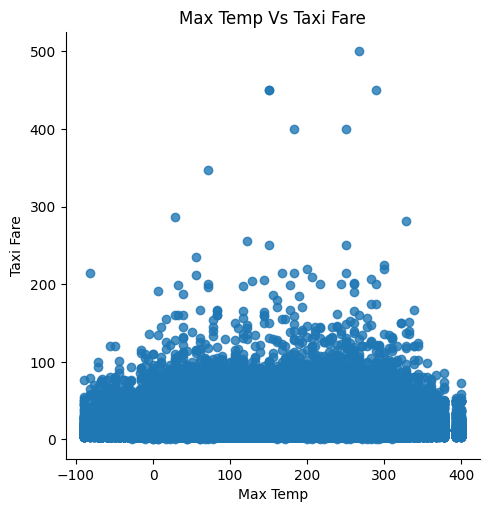

In [52]:
sns.lmplot(x='max_temp', y='fare_amount',data=train)

plt.title('Max Temp Vs Taxi Fare')
# Set x-axis label
plt.xlabel('Max Temp')
# Set y-axis label
plt.ylabel('Taxi Fare')

Text(24.765625000000007, 0.5, 'Taxi Fare')

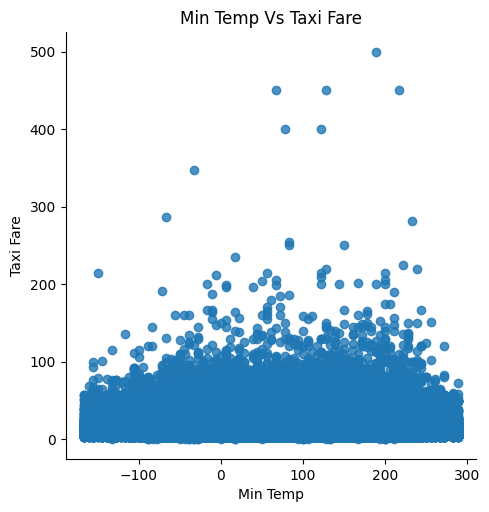

In [53]:
sns.lmplot(x='min_temp', y='fare_amount',data=train)

plt.title('Min Temp Vs Taxi Fare')
# Set x-axis label
plt.xlabel('Min Temp')
# Set y-axis label
plt.ylabel('Taxi Fare')

Text(24.765625000000007, 0.5, 'Taxi Fare')

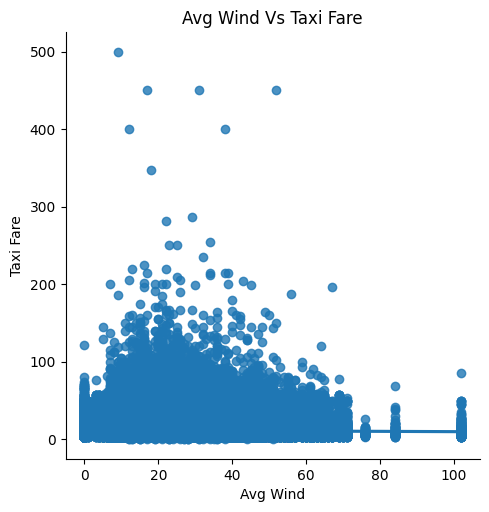

In [54]:
sns.lmplot(x='avg_wind', y='fare_amount', data=train)

plt.title('Avg Wind Vs Taxi Fare')
# Set x-axis label
plt.xlabel('Avg Wind')
# Set y-axis label
plt.ylabel('Taxi Fare')

### PLOTS BETWEEN TRIP DISTANCE AND WEATHER CONDITIONS

Text(33.51562500000001, 0.5, 'Distance of Ride')

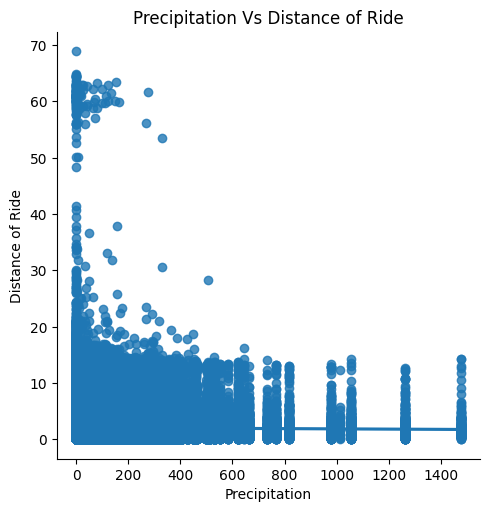

In [55]:
sns.lmplot(x='precipitation', y='hav_distance', data=train)

plt.title('Precipitation Vs Distance of Ride')
# Set x-axis label
plt.xlabel('Precipitation')
# Set y-axis label
plt.ylabel('Distance of Ride')

Text(33.51562500000001, 0.5, 'Distance of Ride')

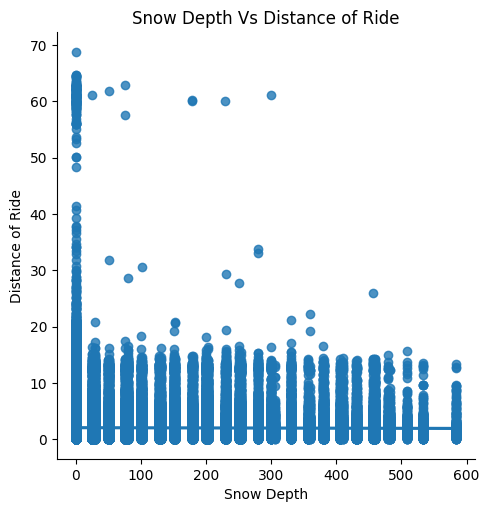

In [56]:
sns.lmplot(x='snow_depth', y='hav_distance', data=train)

plt.title('Snow Depth Vs Distance of Ride')
# Set x-axis label
plt.xlabel('Snow Depth')
# Set y-axis label
plt.ylabel('Distance of Ride')

Text(33.51562500000001, 0.5, 'Distance of Ride')

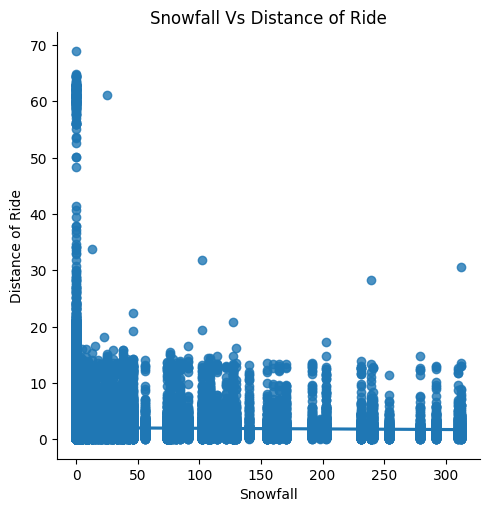

In [57]:
sns.lmplot(x='snowfall', y='hav_distance',data=train)

plt.title('Snowfall Vs Distance of Ride')
# Set x-axis label
plt.xlabel('Snowfall')
# Set y-axis label
plt.ylabel('Distance of Ride')

Text(33.51562500000001, 0.5, 'Distance of Ride')

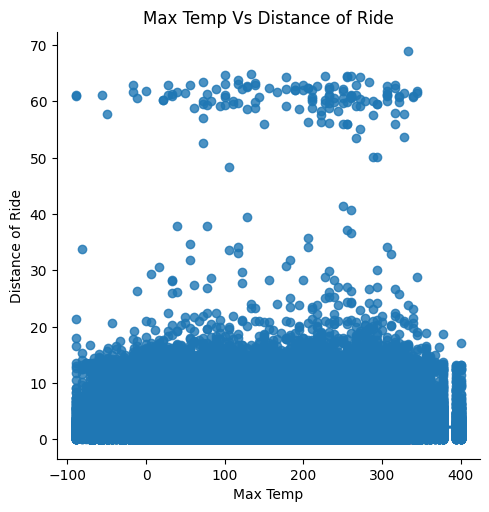

In [58]:
sns.lmplot(x='max_temp', y='hav_distance',data=train)

plt.title('Max Temp Vs Distance of Ride')
# Set x-axis label
plt.xlabel('Max Temp')
# Set y-axis label
plt.ylabel('Distance of Ride')

Text(33.51562500000001, 0.5, 'Distance of Ride')

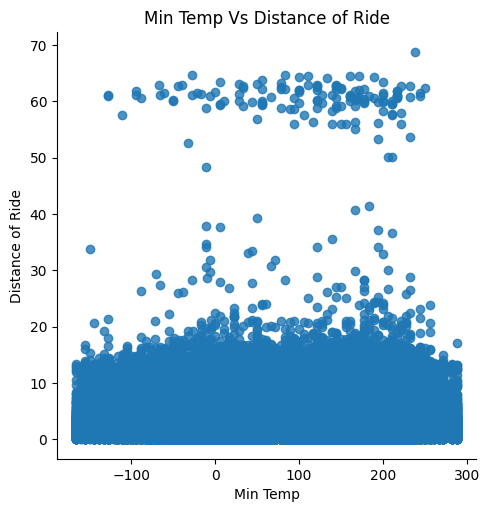

In [59]:
sns.lmplot(x='min_temp', y='hav_distance',data=train)

plt.title('Min Temp Vs Distance of Ride')
# Set x-axis label
plt.xlabel('Min Temp')
# Set y-axis label
plt.ylabel('Distance of Ride')

Text(33.51562500000001, 0.5, 'Distance of Ride')

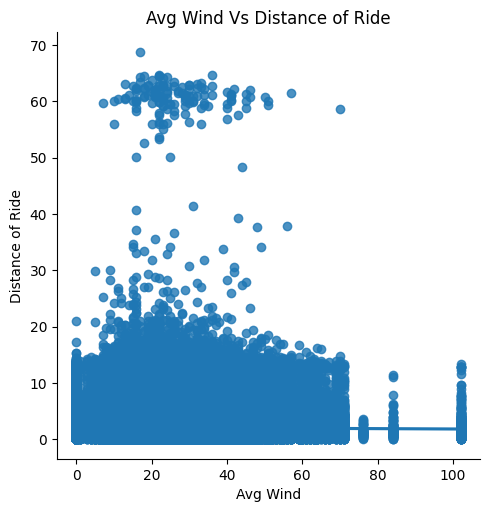

In [60]:
sns.lmplot(x='avg_wind', y='hav_distance', data=train)

plt.title('Avg Wind Vs Distance of Ride')
# Set x-axis label
plt.xlabel('Avg Wind')
# Set y-axis label
plt.ylabel('Distance of Ride')

#### Observations:

Among all the above plots, one common observation is that there is quite a clear relation between the Distance travelled and Taxi Fare, because for the points at the top in the left plots, there are corresponding samples in the right plot as well indicating that Trip Distance and Taxi Fare are indeed correlated.

Now comparing the features one by one:

* Avg Wind - For higher winds the distance travelled is lesser, thus in turn leading the taxi fare to be lesser.

* Precipitation - Similar to Avg Wind, the distance travelled and the fair are low when Precipitation is high.

* Snow Depth and Snow Fall - Here is no decrease in both the rides and the fairs as one might assume the availability of cabs would become lesser. But there is quite a constant curve which could mean that during the snow, people continue to use the cabs all the more due to the harsh weathers.

* Min Temp and Max Temp - This plot was very interesting indicating perfectly that the distance travelled and taxi fares are high when the temperatures are relatively bearable and they reduced when they go under a certain temperature.

#### PROCESSING TEST DATA

In [61]:
# Pre-Processing Test Data

test =  pd.read_csv('./test.csv')
test['pickup_datetime']=pd.to_datetime(test['pickup_datetime'],format='%Y-%m-%d %H:%M:%S UTC')

test['pickup_date']= test['pickup_datetime'].dt.date
test['pickup_day']=test['pickup_datetime'].dt.day
test['pickup_hour']=test['pickup_datetime'].dt.hour
test['pickup_day_of_week']=test['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
test['pickup_month']=test['pickup_datetime'].dt.month
test['pickup_year']=test['pickup_datetime'].dt.year


test['hav_distance']=test.apply(lambda row:haversian_distance(row['pickup_latitude'],row['dropoff_latitude'],row['pickup_longitude'],row['dropoff_longitude']),axis=1)
test['euc_distance'] = 69 * np.sqrt((np.array(test.dropoff_longitude) - np.array(test.pickup_longitude))**2 + (np.array(test.pickup_latitude) - np.array(test.dropoff_latitude))**2)


# Merging with Weather Data to obtain extra Features

test_new = pd.merge(test, weather, how='left', on=['pickup_year','pickup_month','pickup_day'])
print (test_new.columns)

Index(['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_date', 'pickup_day', 'pickup_hour', 'pickup_day_of_week',
       'pickup_month', 'pickup_year', 'hav_distance', 'euc_distance',
       'precipitation', 'snow_depth', 'snowfall', 'max_temp', 'min_temp',
       'avg_wind'],
      dtype='object')


In [62]:
# Checking for NULL Values

test_new[pd.isnull(test_new)].sum()
print (test_new.dtypes)

key                           object
pickup_datetime       datetime64[ns]
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
passenger_count                int64
pickup_date                   object
pickup_day                     int64
pickup_hour                    int64
pickup_day_of_week            object
pickup_month                   int64
pickup_year                    int64
hav_distance                 float64
euc_distance                 float64
precipitation                  int64
snow_depth                     int64
snowfall                       int64
max_temp                       int64
min_temp                       int64
avg_wind                       int64
dtype: object


<ipython-input-62-a533edffae9b>:3: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  test_new[pd.isnull(test_new)].sum()


In [63]:
# Final Test Set that will be Used For Testing

test = test_new
print (test.columns)
print (test.shape)
print (test.dtypes)

Index(['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_date', 'pickup_day', 'pickup_hour', 'pickup_day_of_week',
       'pickup_month', 'pickup_year', 'hav_distance', 'euc_distance',
       'precipitation', 'snow_depth', 'snowfall', 'max_temp', 'min_temp',
       'avg_wind'],
      dtype='object')
(9914, 21)
key                           object
pickup_datetime       datetime64[ns]
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
passenger_count                int64
pickup_date                   object
pickup_day                     int64
pickup_hour                    int64
pickup_day_of_week            object
pickup_month                   int64
pickup_year                    int64
hav_distance                 float64
euc_distance                 float64
precipitation                  int64

#### PREPARING TRAIN AND VALIDATION SET FROM TRAINING DATA

In [64]:
# Considering all the Features except 'Key', 'pickup_date', 'pickup_day_of_week' and 'euc_distance' (as haversian distance is already being considered, and both together could lead to redundant features.)
traindata = train[train.columns[3:]]
traindata = traindata[traindata.columns.difference(['pickup_day_of_week'])]
traindata = traindata[traindata.columns.difference(['pickup_date'])]
traindata = traindata[traindata.columns.difference(['euc_distance'])]

# Trainoutput is the Fare Amount column
trainoutput = train[train.columns[1:2]]

# Considering 2/3rd of the data for Training and 1/3rd for Validation
x, y = traindata.shape
x1 = 2 * int(x / 3)

traindata_X = traindata[0:x1]
testdata_X = traindata[x1:x]

traindata_Y = trainoutput[0:x1]
testdata_Y = trainoutput[x1:x]

x, y
print (traindata.columns)

Index(['avg_wind', 'dropoff_latitude', 'dropoff_longitude', 'hav_distance',
       'max_temp', 'min_temp', 'passenger_count', 'pickup_day', 'pickup_hour',
       'pickup_latitude', 'pickup_longitude', 'pickup_month', 'pickup_year',
       'precipitation', 'snow_depth', 'snowfall'],
      dtype='object')


#### PREPARING TEST DATA

In [65]:
# Considering all Features except 'Key', 'pickup_date', 'pickup_day_of_week'
testdata = test[test.columns[2:]]
testdata = testdata[testdata.columns.difference(['pickup_day_of_week'])]
testdata = testdata[testdata.columns.difference(['pickup_date'])]
testdata = testdata[testdata.columns.difference(['euc_distance'])]

print (testdata.columns)

Index(['avg_wind', 'dropoff_latitude', 'dropoff_longitude', 'hav_distance',
       'max_temp', 'min_temp', 'passenger_count', 'pickup_day', 'pickup_hour',
       'pickup_latitude', 'pickup_longitude', 'pickup_month', 'pickup_year',
       'precipitation', 'snow_depth', 'snowfall'],
      dtype='object')


### PREDICTION MODELS

The following error metrics used to evaluate the models.
    
    ○ Root Mean Square Error (RMSE)
    ○ Mean Squared Error (MSE)
    ○ R2 Score

And the goal is to try to maximize R2 score (1 being the best) while minimizing RMSE and MSE along with ensuring that the model does not overfit.

The following Machine Learning models where used:
    
    ○ Linear Regressor
    ○ Decision Trees
    ○ Random Forest Regressor
    ○ XGB Regressor (without any Hyperparameter Tuning) and
    ○ XGB with Hyperparameters

* Among all the above, XGB with Hyperparameters worked the best providing a score of 3.17502 on the Test data. (which is a very high improvement on the Linear Model that was done initially which got a score of 5.60765)

* The data was split in different proportions to obtain the Train and Validation set and a split of 2/3rd Train and 1/3rd Validation Set along with XGB with Hyperparameters worked the best.


#### LINEAR REGRESSION MODEL

In [66]:
#TRAINING USING LINEAR REGRESSION

regr = linear_model.LinearRegression()
regr.fit(traindata_X, traindata_Y)
testdata_Y_pred_LR = regr.predict(testdata_X)

# The coefficients
print('Coefficients: \n', regr.coef_)

# ERROR METRICS

# Root Mean Square Error
rmse = np.sqrt(mean_squared_error(testdata_Y, testdata_Y_pred_LR))
print("RMSE: %f" % (rmse))

# The Mean Squared Error
print("Mean squared error: %.2f"
      % mean_squared_error(testdata_Y, testdata_Y_pred_LR))

# R2 Score
print('Variance score: %.2f' % r2_score(testdata_Y, testdata_Y_pred_LR))

Coefficients: 
 [[ 1.60929997e-04 -1.36371540e+01  1.07266298e+01  3.16495014e+00
  -1.10849266e-03  4.61756423e-04  3.70720804e-02  1.90155047e-03
   9.94131511e-03 -2.05127099e+01  1.40138653e+01  7.91423303e-02
   5.36076031e-01  2.81981289e-04  1.78000353e-05 -9.99671939e-04]]
RMSE: 5.255454
Mean squared error: 27.62
Variance score: 0.70


The Linear regression model achieved an RMSE = ​5.255454, MSE = 27.62 and R2 score = 0.70.

* For a basic linear model (that could be considered as the baseline model), it did quite okay providing an RMSE = 5.60765 on the Test Data. But, this is definitely not a good model and has to be improved upon.

* For data which is sparse and vast, the linear model might not be able to model it linearly as it involves a lot of real world parameters which might contain outliers along with many other underlying dependencies among the features. Hence, linear regression did not produce that good a result for the problem.

In [69]:
# TESTING USING THE ABOVE MODEL

actual_testdata_pred_lr = regr.predict(testdata)

#EXPORTING PREDICTIONS TO CSV

key = pd.DataFrame(test[test.columns[0:1]])

key['fare_amount'] = actual_testdata_pred_lr
key.to_csv('test_predictions_lr.csv')

##### USING K-FOLD CROSS VALIDATION

Instead of manually splitting the data every time, I also performed K-Fold Cross Validation for the different modules. But I did not see significant betterment in the model through this.

* The whole traindata and trainoutput are used here without splitting. K-Fold does the splitting based on K (Here K=6)

Cross validated scores: [0.66130342 0.66905039 0.69247727 0.70862116 0.69764359 0.70104026]
Cross-Predicted Accuracy: 0.6881388578011916


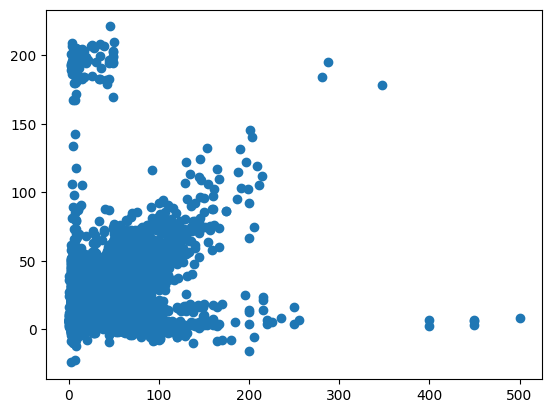

In [70]:
# USING K-FOLD CROSS VALIDATION

scores = cross_val_score(regr, traindata, trainoutput, cv=6)
print ("Cross validated scores:", scores)

predictions = cross_val_predict(regr, traindata, trainoutput, cv=6)
plt.scatter(trainoutput, predictions)

accuracy = metrics.r2_score(trainoutput, predictions)
print ("Cross-Predicted Accuracy:", accuracy)

In [71]:
actual_testdata_pred_lr = regr.predict(testdata)

#EXPORTING PREDICTIONS TO CSV

key = pd.DataFrame(test[test.columns[0:1]])

key['fare_amount'] = actual_testdata_pred_lr
key.to_csv('test_predictions_lr_cv.csv')

#### DECISION TREE REGRESSOR MODEL

In [72]:
# TRAINING USING DECISION TREE REGRESSOR MODEL

dtr = DecisionTreeRegressor().fit(traindata_X, traindata_Y)
testdata_Y_pred_DTR = dtr.predict(testdata_X)

# Error Metrics

# Root Mean Square Error
rmse = np.sqrt(mean_squared_error(testdata_Y, testdata_Y_pred_DTR))
print("RMSE: %f" % (rmse))

# Mean Squared Error
print("Mean squared error: %.2f"
      % mean_squared_error(testdata_Y, testdata_Y_pred_DTR))

# R2 Score
print('Variance score: %.2f' % r2_score(testdata_Y, testdata_Y_pred_DTR))

RMSE: 5.744044
Mean squared error: 32.99
Variance score: 0.64


In [73]:
actual_testdata_pred_dtr = dtr.predict(testdata)

#EXPORTING PREDICTIONS TO CSV

key = pd.DataFrame(test[test.columns[0:1]])

key['fare_amount'] = actual_testdata_pred_dtr
key.to_csv('test_predictions_dtr.csv')

#### RANDOM FOREST REGRESSOR MODEL

In [74]:
#TRAINING USING RANDOM FOREST REGRESSOR

rf = RandomForestRegressor()
rf.fit(traindata_X, traindata_Y)
testdata_Y_pred_RFR = rf.predict(testdata_X)

# Error Metrics

# Root Mean Square Error
rmse = np.sqrt(mean_squared_error(testdata_Y, testdata_Y_pred_RFR))
print("RMSE: %f" % (rmse))

# Mean Squared Error
print("Mean squared error: %.2f"
      % mean_squared_error(testdata_Y, testdata_Y_pred_RFR))

# R2 Score
print('Variance score: %.2f' % r2_score(testdata_Y, testdata_Y_pred_RFR))

<ipython-input-74-542ab3aab389>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(traindata_X, traindata_Y)


RMSE: 3.769659
Mean squared error: 14.21
Variance score: 0.85


In [75]:
actual_testdata_pred_rfr = rf.predict(testdata)

#EXPORTING PREDICTIONS TO CSV

key = pd.DataFrame(test[test.columns[0:1]])

key['fare_amount'] = actual_testdata_pred_rfr
key.to_csv('test_predictions_rfr.csv')

#### XGB REGRESSOR

In [76]:
#TRAINING USING XGB REGRESSOR

xg_reg = xgb.XGBRegressor()
xg_reg.fit(traindata_X,traindata_Y)
testdata_Y_pred_XGB = xg_reg.predict(testdata_X)

# Error Metrics

# Root Mean Square Error
rmse = np.sqrt(mean_squared_error(testdata_Y, testdata_Y_pred_XGB))
print("RMSE: %f" % (rmse))

# Mean Square Error
print("Mean squared error: %.2f"
      % mean_squared_error(testdata_Y, testdata_Y_pred_XGB))

# R2 Score
print('Variance score: %.2f' % r2_score(testdata_Y, testdata_Y_pred_XGB))

RMSE: 3.813862
Mean squared error: 14.55
Variance score: 0.84


In [77]:
actual_testdata_pred_xgb = xg_reg.predict(testdata)

#EXPORTING PREDICTIONS TO CSV

key = pd.DataFrame(test[test.columns[0:1]])

key['fare_amount'] = actual_testdata_pred_xgb
key.to_csv('test_predictions_xgb.csv')

#### XGB WITH HYPERPARAMETERS

In [78]:
dtrain = xgb.DMatrix(traindata_X, label=traindata_Y)
dtest = xgb.DMatrix(testdata_X)

#set parameters for xgboost
params = {'max_depth':7,
          'eta':1,
          'silent':1,
          'objective':'reg:linear',
          'eval_metric':'rmse',
          'learning_rate':0.1
         }
num_rounds = 50

xb = xgb.train(params, dtrain, num_rounds)

y_pred_xgb = xb.predict(dtest)

rmse = np.sqrt(mean_squared_error(testdata_Y, y_pred_xgb))
print("RMSE: %f" % (rmse))

print("Mean squared error: %.2f"
      % mean_squared_error(testdata_Y, y_pred_xgb))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(testdata_Y, y_pred_xgb))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [02:55:32] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [02:55:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


RMSE: 3.854023
Mean squared error: 14.85
Variance score: 0.84


In [79]:
# Changing the parameter for better performance
dtrain = xgb.DMatrix(traindata_X, label=traindata_Y)
dtest = xgb.DMatrix(testdata_X)

#Set parameters for xgboost
params = {'max_depth':9,
          'eta':1,
          'silent':1,
          'objective':'reg:linear',
          'eval_metric':'rmse',
          'learning_rate':0.1
         }
num_rounds = 100

xb = xgb.train(params, dtrain, num_rounds)

y_pred_xgb = xb.predict(dtest)

# Error Metrics

# Root Mean Square Error
rmse = np.sqrt(mean_squared_error(testdata_Y, y_pred_xgb))
print("RMSE: %f" % (rmse))

# Mean Squared Error
print("Mean squared error: %.2f"
      % mean_squared_error(testdata_Y, y_pred_xgb))

# R2 Score
print('Variance score: %.2f' % r2_score(testdata_Y, y_pred_xgb))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [02:55:42] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [02:55:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


RMSE: 3.773707
Mean squared error: 14.24
Variance score: 0.85


Tried changing the Parameters again.

**This gave the best performance among all the previous models.**

In [80]:
dtrain = xgb.DMatrix(traindata_X, label=traindata_Y)
dtest = xgb.DMatrix(testdata_X)

#set parameters for xgboost
params = {'max_depth':10,
          'eta':1,
          'silent':1,
          'objective':'reg:linear',
          'eval_metric':'rmse',
          'learning_rate':0.15
         }
num_rounds = 100

xb = xgb.train(params, dtrain, num_rounds)

y_pred_xgb = xb.predict(dtest)

# Error Metrics

# Root Mean Square Error
rmse = np.sqrt(mean_squared_error(testdata_Y, y_pred_xgb))
print("RMSE: %f" % (rmse))

# Mean Squared Error
print("Mean squared error: %.2f"
      % mean_squared_error(testdata_Y, y_pred_xgb))

# R2 Score
print('Variance score: %.2f' % r2_score(testdata_Y, y_pred_xgb))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [02:56:05] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [02:56:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


RMSE: 3.816074
Mean squared error: 14.56
Variance score: 0.84


In [81]:
dtest_actual = xgb.DMatrix(testdata)
actual_testdata_pred_xgb_params = xb.predict(dtest_actual)

#EXPORTING PREDICTIONS TO CSV

key = pd.DataFrame(test[test.columns[0:1]])

key['fare_amount'] = actual_testdata_pred_xgb_params
key.to_csv('test_predictions_xgb_params.csv')

Below Plot shows the importance of each feature towards building the Prediction Model.

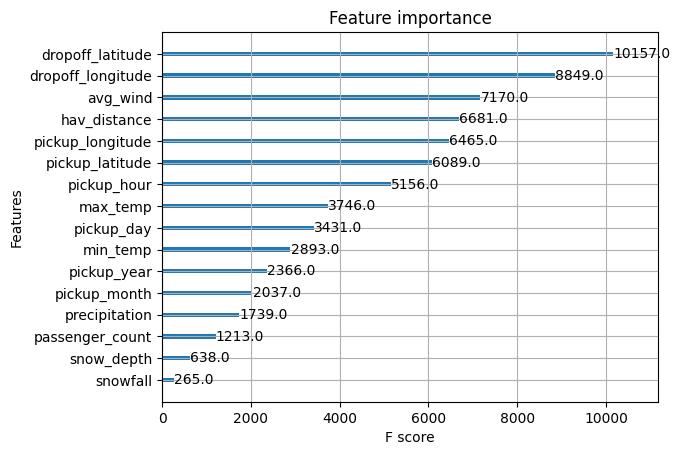

In [82]:
xgb.plot_importance(xb)
plt.rcParams['figure.figsize'] = [7, 7]
plt.show()

### Observations:

The RMSE score for the different models on the Test Data was as follows:
    
    ○ Linear Regression - RMSE score = 5.26
    ○ Decision Trees - RMSE score = ​5.74 (was worse than Linear Model)
    ○ Random Forest Regressor - RMSE score = ​3.77 (drastic improvement from here on)
    ○ XGB Regressor without parameters - RMSE score = ​3.81
    ○ XGB Regressor with Parameters - RMSE score after tuning the parameters few times = 3.82

* Takeaway from this practice was that real world datasets ( considering most dataset are actually real world) are extremely complicated and visualizing this kind of data in order to understand the data better requires efforts.
